In [166]:
#Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet

In [167]:
# --- Import of prestation data ---

#Read the data
df_pres = pd.read_csv('data/transport_performance.csv', sep=';')

#Initialise prestation data
df_pres['Periods'] = pd.to_numeric(df_pres['Periods'], errors='coerce')
df_pres['Transport performance (billion passenger kilometres )'] = pd.to_numeric(df_pres['Transport performance (billion passenger kilometres )'], errors='coerce')

#Rename columns
df_pres.rename({'Transport performance (billion passenger kilometres )': 'Total travel'}, axis=1, inplace=True)

#Drop unnesecary columns
df_pres.drop('Margins', axis=1, inplace=True)
df_pres.drop('Population', axis=1, inplace=True)

df_pres.head()


,Modes of travel,Region characteristics,Periods,Total travel
0,Total,The Netherlands,2018,218.1
1,Total,The Netherlands,2019,218.8
2,Total,The Netherlands,2020,152.0
3,Total,The Netherlands,2021,168.4
4,Total,The Netherlands,2022,186.9


In [168]:
# --- Import of mobility data ---

df_mob = pd.read_csv('data/mobility_trends.csv', sep=';')

#initialise data

df_mob['ds'] = df_mob['Periods'].str[:-1] + '-01-01'
df_mob['ds'] = pd.to_datetime(df_mob['ds'])
df_mob['Stages per person per day (average) (number)'] = df_mob['Stages per person per day (average) (number)'].astype(float)

df_mob.head()


,Sex,Age,Modes of travel,Travel motives,Margins,Periods,Stages per person per day (average) (number),Distance travelled per stage (average) (passenger kilometres),Average travel time per stage (Minutes),ds
0,Total male and female,Total,Total,Total,Value,1999*,3.41,10.96,23.72,1999-01-01
1,Total male and female,Total,Total,Total,Value,2000*,3.35,11.00,23.73,2000-01-01
2,Total male and female,Total,Total,Total,Value,2001*,3.30,10.99,23.67,2001-01-01
3,Total male and female,Total,Total,Total,Value,2002*,3.30,11.01,23.49,2002-01-01
4,Total male and female,Total,Total,Total,Value,2003*,3.30,11.04,23.65,2003-01-01


In [169]:
#Create first forecast dataframe

df_forecast = df_mob[(df_mob['Modes of travel']=='Total') & (df_mob['Travel motives']== 'Total')].copy()
df_forecast = df_forecast.rename(columns={'Stages per person per day (average) (number)': 'y'})
df_forecast.tail()

,Sex,Age,Modes of travel,Travel motives,Margins,Periods,y,Distance travelled per stage (average) (passenger kilometres),Average travel time per stage (Minutes),ds
20,Total male and female,Total,Total,Total,Value,2019*,2.97,11.64,24.18,2019-01-01
21,Total male and female,Total,Total,Total,Value,2020*,2.48,9.67,24.46,2020-01-01
22,Total male and female,Total,Total,Total,Value,2021*,2.62,10.00,26.03,2021-01-01
23,Total male and female,Total,Total,Total,Value,2022*,2.86,10.22,24.88,2022-01-01
24,Total male and female,Total,Total,Total,Value,2023*,2.93,10.59,24.63,2023-01-01


In [170]:
# --- Forecast first model with mobility data ---
m = Prophet()
m.fit(df_forecast)
prediction = m.make_future_dataframe(periods=5, freq='Y')
forecast = m.predict(prediction)

12:17:02 - cmdstanpy - INFO - Chain [1] start processing
12:17:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\raxo1\anaconda3\envs\TIL_programming\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [171]:
# --- Forecast second model with prestation data ---

#Restructing of data
df_m2 = df_pres[(df_pres['Modes of travel']=='Total') & (df_pres['Region characteristics']=='The Netherlands')].copy()
df_m2 = df_m2.rename(columns={'Total travel': 'y'})

df_m2['ds'] = df_m2['Periods'].astype(str) + '-01-01'
df_m2['ds'] = pd.to_datetime(df_m2['ds'])

#Add covid as an event to the model
df_m2['covid'] = 0
df_m2.loc[(df_m2['Periods'] == 2020), 'covid'] = 1
df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5

#Fit the model
m2 = Prophet(changepoint_prior_scale=0.1)
m2.add_regressor('covid')
m2.fit(df_m2)

#Predict future
prediction_m2 = m2.make_future_dataframe(periods=10, freq='YE')
prediction_m2['covid'] = 0
forecast_m2 = m2.predict(prediction_m2)

C:\Users\raxo1\AppData\Local\Temp\ipykernel_35824\397908819.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_m2.loc[(df_m2['Periods'] == 2021), 'covid'] = 0.5
12:17:02 - cmdstanpy - INFO - Chain [1] start processing
12:17:02 - cmdstanpy - INFO - Chain [1] done processing


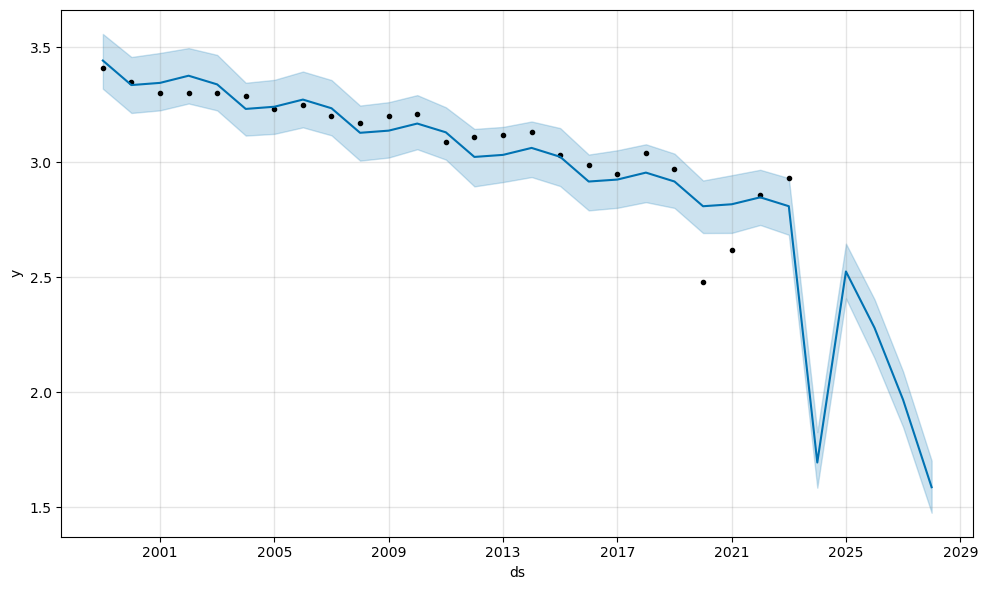

In [172]:
fig1 = m.plot(forecast)
plt.show()

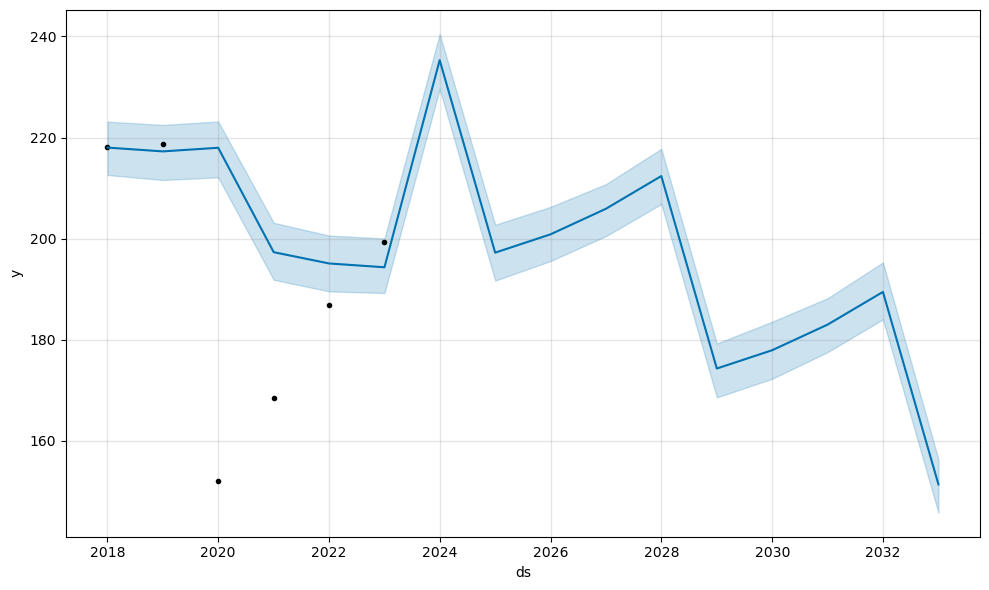

In [173]:
fig2 = m2.plot(forecast_m2)
plt.show()

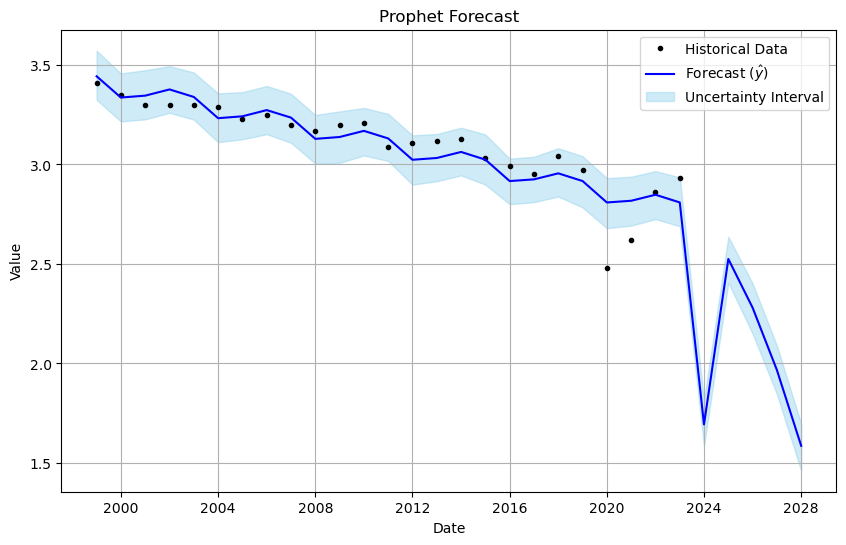

In [174]:
# --- OLD ---

# ... your code to fit and predict ...
forecast = m.predict(prediction)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the historical data (optional, only if df_forecast contains 'y')
plt.plot(df_forecast['ds'], df_forecast['y'], 'k.', label='Historical Data')

# Plot the forecast line
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast ($\hat{y}$)')

# Plot the uncertainty interval (shaded area)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.4,
    label='Uncertainty Interval'
)

# Add labels and title
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()